## Introducao

### Sobre a escolha de arquiteturas

Apos ler um pouco sobre possiveis metodologias de selecao de arquiteturas de redes neurais, prontamente percebi a existencia de um consenso de que a definicao de arquiteturas eh um processo bastante empirico e que varia bastante de acordo com a complexidade da distribuicao que impera sobre cada base de dados. Assim, nao existe uma unica arquitetura que vai funcionar para todos os datasets.

Todavia alguns em minhas leituras indentifiquei algumams intuicoes sao validas como 'rules-of-thumb' para um largo espectro de problemas.Dentre essas intuicoes escolhi algumas que me guiaram na elaboracao das arquitetures que utilizei neste TP


## Intuicoes e rules-of-thumb escolhidos: DropOut

A primeira delas, eh que o processo de treinamento de redes neurais sofre cronicamente com problemas de overffiting. Neuronios com muita facilidade acabam criando relacoes muito fortes com alguns poucos neuronios especificos da camada anterior a eles, muitas vezes comprometendo severam a capacidade de generalizacao da rede

Nesse contexto a nocao de aleatoriamente desligar um parcela de neuronios da camada anterior durante o processo de treinamento forca a rede a aprender representacoes mais generalizaveis do dado de entrada... Ou seja, que sao mais uteis para um espectro maior de entrada e nao apenas algumas entradas especificadas da base de treinamento

Assim, o Dropout eh uma ferramente extramemente poderosa para os tipos de rede neural que estamos utilizando neste TP portanto pode e deve ser utilizado com frequencia


## Intuicoes e rules-of-thumb escolhidos: padroes dos tamanhos de camadas

O segundo principal elemento que frequentemente apareceu em minhas pesquisas por boas arquiteturas surgiu na forma da progressao dos tamanhos das camadas tanto das redes neurais quanto nas redes neurais convolucionais

Observei que muitas vezes opta-se por fazer um progressao em potencias de 2 quando estamos decidindo tanto o numero de neuronios em uma camada de NN's quanto o numero de filtros em uma CNN. Nao encontrei respostas conclusivas sobre o porque isso eh feito todavia desenvolvi duas intuicoes que me ajudaram a acreditar nesta pratica comum:










## Intuicoes e rules-of-thumb escolhidos: progressao no numero de filtros em RNNs

No caso das RNNS, observei que as progressoes no numero de filtros a medida que fazemos mais convolucoes tende a aumentar em potencias de dois, tal como 8 -> 16 -> 32. Acredito que a intuicao que justifica essa pratica eh que em cada camada convolucional os filtros estao la para tentar capturar padroes na imagem.. Entao podemos imaginar que os primeiros filtros capturam padroes mais simples como quinas e linha verticais/horizontais.. Com esses padroes em maos queremos entao combina-los em padroes maiores e mais complexos.. Assim como os padroes ficam mais e mais compleos a medida que avancamos nas camadas convolucionais, temos cada vez mais possiveis padroes que podem ser formados.. Assim, progressivamente aumentamos o numero de filtros: para capturar a maior quantidade de combinacoes uteis possiveis

## Intuicoes e rules-of-thumb escolhidos: progressao no numero de neuronios em NNs

No caso das NNs, observei que as progressoes geralmente diminuem em potencias de dois tal como 1024 -> 512 ->256..
Acredito que a motivacao por tras disso eh que queremos que rede neural desenvolva novas representacoes cada vez mais elaboradas e compostas do dado rebido na entrada.. Assim, embora tenhamos recebido 1024 features de entrada, eh interessante para a classificao final que a rede neural extraia representacoes cada vez mais poderosas para o dado.. Para tal, ao forcamos a reducao no numero de neuronios, forcamos que a rede aprenda nocoes que contenham uma densidade cada vez maior de representacoes uteis para a classificacao

# Juntando tudo: meu bloco denso e meu bloco convolucional

Tendo absorvido essas intuicoes, criei um bloco denso padrao e um bloco convolucional padrao que entao posso empilhar multiplas vezes sequencialmente na hora de montar minhas redes

Bloco convolucional: Conv2D com x filtros -> Dropout -> Conv2D com x*2 filtros -> Maxpooling2D

Bloco denso: Dropout -> Dense com x/2 neuronios  (Se no bloco anterior haviam x neuronios na camada)

(Aqui ressalto que o x da primeira camada de um bloco eh o x da ultima camada do bloco anterior)

Assim minha arquitetura NN tornou-se uma conjuncao de multiplos desse bloco denso e minha arquitetura CNN tornou-se uma conjuncao de multiplos desse bloco convolucional (para extrair features) seguidos de multiplos do bloco denso para fazer a classificao

## Como escolhi o numero de blocos a utilizar e os hiperparametros?

Fiz uma mini verso do que eu entendi ser o tal *grid search*! 

Para cada um dos hiperparametros que surgem das intuicoes que explicitei acima, fiz um grid search utilizando bons candidatos para cada parametro

Em outras palavras, treinei uma nova rede para cada possivel combinacao dos hiperparametros relevantes

Ao final, os seguintes hiperpametros foram decididos dessa forma:

    O numero de blocos densos na minha rede NN
    
    O numero de blocos densos na minha rede CNN
    
    O numero de blocos convolucionais na minha rede CNN
    
    O learning rate tanto da minha CNN quanto da minha NN
    
    O dropout rate tanto da minha CNN quando da minha NN
    
    
Assim ao final treinei 

4 redes neurais variando o numero de blocos densos
4 redes neurais variando o learning rate e o dropout rate

4 redes neurais convolucionais variando o numero de blocos densos e o numero de blocos convolucionais
4 redes neurais convolucionais variando o learning rate e o dropout rate

Ao final utilizei a acuracia no conjunto de validacao para escolhar qual a melhor RNN e qual a melhor NN



### Sobre outros hiperparametros:

Professor, como pode ver acima optei por fazer um grid search extenso (para um computador pessoal..) nos hiperparametros das intuicoes que escolhi como guias na hora de escolher a arquitetura da minha rede..

Entao por motivos de complexidade computacional, outros parametros como batch_size e numero de epocas foram escolhidos de forma puramente empirica em redes que treinei manualmente "on the side" ..

Espero que entenda que eu poderia muito bem ter feito o mesmo processo de grid search com eles.. Mas incluir esses parametros a mais no meu grid search pelo menos quadruplicaria meu tempo de treinamento, que ja foi muito longo.. Isso tornaria meu tempo de iteracao em modificacoes no meu TP demasiadamente lento

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import AUC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
#Funcao de plotagem da matriz de confusao que sempre utilizo em meus trablalhos
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Oranges):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.set_xticklabels(classes)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    plt.xlim(-0.5, len(np.unique(y_true))-0.5)
    plt.ylim(len(np.unique(y_true))-0.5, -0.5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            #ax.text(j, i, format(cm[i, j], fmt),
            ax.text(j, i, format(annot[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
from keras.datasets import cifar10
from matplotlib import pyplot

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=1) # 0.25 x 0.8 = 0.2

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(47500, 32, 32, 3)
(47500, 1)
(10000, 32, 32, 3)
(10000, 1)
(2500, 32, 32, 3)
(2500, 1)


###### Normalização das features

In [5]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

###### One-hot dos labels

In [6]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

num_classes = y_test.shape[1]

###### Criando gerador de data augmentation para uso na LeNet e na CNN

In [7]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# LeNet5

In [8]:

model_LeNet = Sequential()
#A dimensao do output da Cond2D eh (dimensao original - dimensao do filtro mais + 1)
#Assim como queremos output 28x28 para entrada 32x32 utilizados filtro 5x5 
model_LeNet.add(Conv2D(6, kernel_size=(5,5), padding='valid', activation='tanh', input_shape=(32, 32, 3)))
#Agora pela modelagem original da LeNet 5 queremos um pooling que resulte em 14x14 saindo de 28x28 logo usamos stride 2
model_LeNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
#Mesma logica do primmeiro Conv2D, so que queremos output 10x10 para 16 filtros
model_LeNet.add(Conv2D(16, kernel_size=(5, 5), activation='tanh', padding='valid'))
#Novamente queremos reduzir a dimensao pela metade na saida do pooling
model_LeNet.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model_LeNet.add(Flatten())
model_LeNet.add(Dense(120, activation='tanh'))
model_LeNet.add(Dense(84, activation='tanh'))
model_LeNet.add(Dense(10, activation='softmax'))
lrate = 0.001
adam = Adam(learning_rate = lrate)
model_LeNet.compile(loss='categorical_crossentropy', optimizer= adam, metrics=['accuracy']) 
#print(model_LeNet.summary())


In [9]:
epochs = 10
batch_size = 64

aug_train = datagen.flow(X_train, y_train, batch_size= batch_size)
steps = int(X_train.shape[0] / batch_size )
history_LeNet = model_LeNet.fit_generator(aug_train, steps_per_epoch=steps, epochs=epochs, validation_data=(X_val, y_val))
# Final evaluation of the model
scores_LeNet = model_LeNet.evaluate(X_test, y_test, verbose=0)
print("Accuracy em teste da LeNet5: %.2f%%" % (scores_LeNet[1]*100))


/home/joaocouto/miniconda3/envs/gargantua/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
742/742 [==============================] - 25s 28ms/step - loss: 1.8362 - accuracy: 0.3328 - val_loss: 1.4530 - val_accuracy: 0.4856
Epoch 2/10
742/742 [==============================] - 15s 20ms/step - loss: 1.4758 - accuracy: 0.4705 - val_loss: 1.3223 - val_accuracy: 0.5208
Epoch 3/10
742/742 [==============================] - 15s 20ms/step - loss: 1.3773 - accuracy: 0.5104 - val_loss: 1.3043 - val_accuracy: 0.5364
Epoch 4/10
742/742 [==============================] - 15s 20ms/step - loss: 1.3099 - accuracy: 0.5342 - val_loss: 1.2609 - val_accuracy: 0.5556
Epoch 5/10
742/742 [==============================] - 16s 22ms/step - loss: 1.2585 - accuracy: 0.5566 - val_loss: 1.1941 - val_accuracy: 0.5708
Epoch 6/10
742/742 [==============================] - 15s 20ms/step - loss: 1.2266 - accuracy: 0.5655 - val_loss: 1.2542 - val_accuracy: 0.5576
Epoch 7/10
742/742 [==============================] - 14s 19ms/step - loss: 1.1938 - accuracy: 0.5765 - val_loss: 1.1825 - val_accuracy:

# Matriz de confusao LeNet5

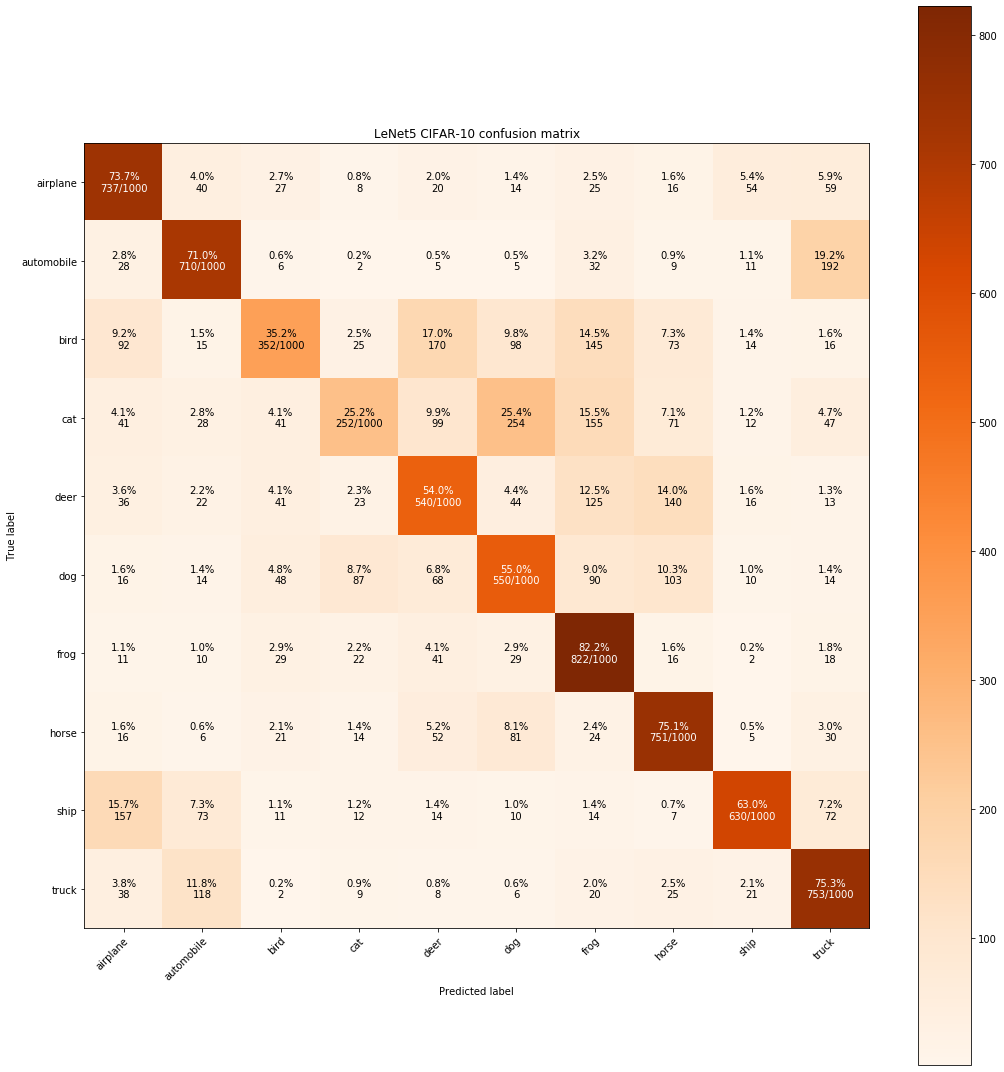

In [10]:
a = model_LeNet.predict(X_test)
max_index_row_pred = np.argmax(a, axis=1)
max_index_row_test = np.argmax(y_test, axis=1)

label_names = ['airplane','automobile','bird','cat',  'deer','dog','frog','horse','ship', 'truck']

plot_confusion_matrix(max_index_row_test, max_index_row_pred, 
                      #classes=['0' ,'1','2','5', '6', '7', '4', '8', '3','9'],
                      classes= label_names,
                      title='LeNet5 CIFAR-10 confusion matrix',
                     cmap = plt.cm.Oranges
                     )


# NN

In [11]:
def nn(dropout_rate,dense_count,num_classe,learning_rate):
    if (dense_count < 1):
        return 'Favor inserir pelo menos um block denso'
    
    model = Sequential()
    
    neuron_count = 2048
    for j in range(1,dense_count+1):
        neuron_count = neuron_count/2
        if(neuron_count == 1):
            return "Camadas densas demais, maximo 10 por favor"
    
        if(j==1):
            model.add(Dense(neuron_count, input_dim=3072, activation='relu'))
        if(j==dense_count):
            model.add(Dropout(dropout_rate))
            model.add(Dense(num_classes, activation='softmax'))
        else:
            model.add(Dropout(dropout_rate))
            model.add(Dense(neuron_count, activation='relu', kernel_constraint=maxnorm(3))) 
    
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model
    
    

## Escolhendo arquitetura da NN:

In [12]:
fixed_epochs = 10
fixed_batch_size = 32
fixed_dropout_rate = 0.2
fixed_lrate = 0.001

In [13]:
dense_block_options = [3,4,5,6]


max_accuracy = 0
best_dense_block_size = 0

X_train_flat = X_train.reshape(47500, 3072)
X_test_flat = X_test.reshape(10000, 3072)
X_val_flat = X_val.reshape(2500, 3072)




for dense_block_num in dense_block_options:
    model_NN = nn(fixed_dropout_rate,
                  dense_block_num,
                  num_classes,
                  fixed_lrate)
    
    history_NN = model_NN.fit(X_train_flat, y_train, 
                                validation_data=(X_val_flat, y_val), 
                                epochs=fixed_epochs, 
                                batch_size=fixed_batch_size, 
                                verbose=1)
    
    if(history_NN.history["val_accuracy"][-1] > max_accuracy):
        max_accuracy = history_NN.history["val_accuracy"][-1]
        best_dense_block_size = dense_block_num
        print("Trocou! Novo melhor numero de blocos densos eh",best_dense_block_size)
        

Epoch 1/10
1485/1485 [==============================] - 3s 2ms/step - loss: 2.1102 - accuracy: 0.2287 - val_loss: 1.8885 - val_accuracy: 0.3248
Epoch 2/10
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8947 - accuracy: 0.3046 - val_loss: 1.8302 - val_accuracy: 0.3516
Epoch 3/10
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8556 - accuracy: 0.3208 - val_loss: 1.7868 - val_accuracy: 0.3544
Epoch 4/10
1485/1485 [==============================] - 4s 2ms/step - loss: 1.8145 - accuracy: 0.3400 - val_loss: 1.7347 - val_accuracy: 0.3800
Epoch 5/10
1485/1485 [==============================] - 3s 2ms/step - loss: 1.8004 - accuracy: 0.3476 - val_loss: 1.7972 - val_accuracy: 0.3700
Epoch 6/10
1485/1485 [==============================] - 3s 2ms/step - loss: 1.7917 - accuracy: 0.3497 - val_loss: 1.7444 - val_accuracy: 0.3984
Epoch 7/10
1485/1485 [==============================] - 3s 2ms/step - loss: 1.7810 - accuracy: 0.3550 - val_loss: 1.6933 - val_accuracy:

# Escolhendo melhores hiperparametros para a NN 

In [14]:
lrate_options = [0.002,0.001]
dropout_rate_options = [0.2,0.3]

best_lrate = 0
best_dropout_rate = 0

max_accuracy = 0
for lrate_num in lrate_options:
    for dropout_rate_num in dropout_rate_options:
        model_NN = nn(dropout_rate_num,best_dense_block_size,num_classes,lrate_num)
        history_NN = model_NN.fit(X_train_flat, y_train, 
                                    validation_data=(X_val_flat, y_val), 
                                    epochs=fixed_epochs, 
                                    batch_size=fixed_batch_size, 
                                    verbose=1)
        if(history_NN.history["val_accuracy"][-1] > max_accuracy):
            max_accuracy = history_NN.history["val_accuracy"][-1]
            
            best_lrate = lrate_num
            
            best_dropout_rate = dropout_rate_num
            print("Trocou! Novo melhor learning rate eh",best_lrate)
            print("Trocou! Novo melhor dropout rate eh ",best_dropout_rate)
        
        
        


Epoch 1/10
1485/1485 [==============================] - 4s 2ms/step - loss: 2.2538 - accuracy: 0.1621 - val_loss: 2.0089 - val_accuracy: 0.2120
Epoch 2/10
1485/1485 [==============================] - 4s 3ms/step - loss: 2.0704 - accuracy: 0.2017 - val_loss: 1.9892 - val_accuracy: 0.2396
Epoch 3/10
1485/1485 [==============================] - 3s 2ms/step - loss: 2.0278 - accuracy: 0.2178 - val_loss: 2.0291 - val_accuracy: 0.2288
Epoch 4/10
1485/1485 [==============================] - 4s 3ms/step - loss: 2.0218 - accuracy: 0.2251 - val_loss: 2.0110 - val_accuracy: 0.2304
Epoch 5/10
1485/1485 [==============================] - 3s 2ms/step - loss: 2.0074 - accuracy: 0.2315 - val_loss: 1.9598 - val_accuracy: 0.2568
Epoch 6/10
1485/1485 [==============================] - 4s 2ms/step - loss: 1.9863 - accuracy: 0.2423 - val_loss: 1.9555 - val_accuracy: 0.2684
Epoch 7/10
1485/1485 [==============================] - 4s 2ms/step - loss: 1.9953 - accuracy: 0.2379 - val_loss: 1.9550 - val_accuracy:

# Treinando a melhor NN encontrada

In [15]:
best_NN_epoch = 15
best_NN_batch_size = 64

In [16]:
best_NN_model = nn(best_dropout_rate,
                     best_dense_block_size,
                     num_classes,
                     best_lrate)

best_NN_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)              

In [17]:
history_NN = best_NN_model.fit(X_train_flat, y_train, 
            validation_data=(X_val_flat, y_val), 
            epochs=best_NN_epoch, 
            batch_size= best_NN_batch_size)

scores_NN = best_NN_model.evaluate(X_test_flat, y_test, verbose=0)
print("Accuracy em teste da melhor NN: %.2f%%" % (scores_NN[1]*100))

Epoch 1/15
743/743 [==============================] - 2s 2ms/step - loss: 2.1592 - accuracy: 0.2011 - val_loss: 1.8836 - val_accuracy: 0.3180
Epoch 2/15
743/743 [==============================] - 2s 2ms/step - loss: 1.8963 - accuracy: 0.3024 - val_loss: 1.8243 - val_accuracy: 0.3448
Epoch 3/15
743/743 [==============================] - 2s 2ms/step - loss: 1.8583 - accuracy: 0.3225 - val_loss: 1.8072 - val_accuracy: 0.3564
Epoch 4/15
743/743 [==============================] - 2s 2ms/step - loss: 1.8312 - accuracy: 0.3334 - val_loss: 1.7684 - val_accuracy: 0.3752
Epoch 5/15
743/743 [==============================] - 2s 2ms/step - loss: 1.8022 - accuracy: 0.3462 - val_loss: 1.7179 - val_accuracy: 0.3852
Epoch 6/15
743/743 [==============================] - 2s 2ms/step - loss: 1.7859 - accuracy: 0.3573 - val_loss: 1.7388 - val_accuracy: 0.3888
Epoch 7/15
743/743 [==============================] - 2s 2ms/step - loss: 1.7550 - accuracy: 0.3613 - val_loss: 1.7249 - val_accuracy: 0.3788
Epoch 

# Matriz de confusao da melhor NN encontrada

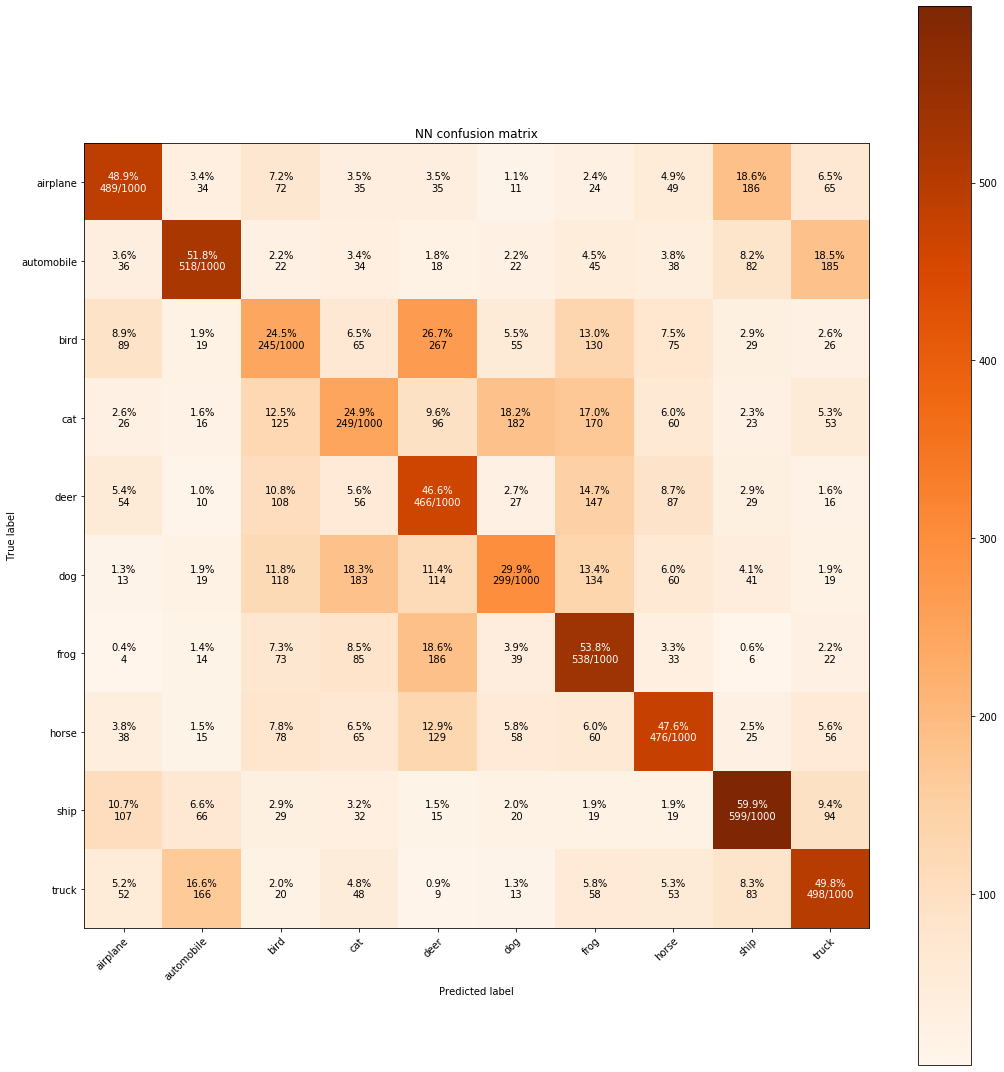

In [18]:
pred_best_nn = best_NN_model.predict(X_test_flat)
max_index_row_pred = np.argmax(pred_best_nn, axis=1)
max_index_row_test = np.argmax(y_test, axis=1)

label_names = ['airplane','automobile','bird','cat',  'deer','dog','frog','horse','ship', 'truck']

plot_confusion_matrix(max_index_row_test, max_index_row_pred, 
                      #classes=['0' ,'1','2','5', '6', '7', '4', '8', '3','9'],
                      classes= label_names,
                      title='NN confusion matrix',
                     cmap = plt.cm.Oranges
                     )

# CNN

In [19]:
def cnn(dropout_rate, conv_block_count, dense_count, num_classes, learning_rate):
    if conv_block_count < 1 or dense_count < 1:
        return 'Favor inserir pelo menos um block denso e um block conv'
    model = Sequential()
    filter_count = 16
    for i in range(1, conv_block_count+1):
        filter_count = filter_count * 2
        if (i ==1):
            model.add(Conv2D(filter_count, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
            model.add(Dropout(dropout_rate)) 
            model.add(Conv2D(filter_count, (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D())
        else:
            model.add(Conv2D(filter_count, (3, 3), activation='relu', padding='same'))
            model.add(Dropout(dropout_rate))
            model.add(Conv2D(filter_count, (3, 3), activation='relu', padding='same'))
            model.add(MaxPooling2D())
    model.add(Flatten())
    neuron_count = 2048
    for j in range(1,dense_count+1):
        neuron_count = neuron_count/2
        if(neuron_count == 1):
            return "Camadas densas demais, maximo 10 por favor"
        if (j==dense_count):
            model.add(Dropout(dropout_rate))
            model.add(Dense(num_classes, activation='softmax'))
        else:
            model.add(Dropout(dropout_rate))
            model.add(Dense(neuron_count, activation='relu', kernel_constraint=maxnorm(3))) 
            
            
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    
    return model

### Escolhendo a arquitetura da CNN

In [20]:
fixed_epochs = 10
fixed_batch_size = 64

In [21]:
conv_block_options = [2,3]
dense_block_options = [3,4]
lrate = 0.001
dropout_rate = 0.2
max_accuracy = 0
best_conv_block_size = 0
best_dense_block_size = 0



for conv_block_num in conv_block_options:
    for dense_block_num in dense_block_options:
        model_CNN = cnn(dropout_rate,conv_block_num,dense_block_num,num_classes,lrate)
        history_CNN = model_CNN.fit(X_train, y_train, 
                                    validation_data=(X_val, y_val), 
                                    epochs=fixed_epochs, 
                                    batch_size=fixed_batch_size, 
                                    verbose=1)
        if(history_CNN.history["val_accuracy"][-1] > max_accuracy):
            max_accuracy = history_CNN.history["val_accuracy"][-1]
            best_conv_block_size = conv_block_num
            best_dense_block_size = dense_block_num
            print("Trocou! Novo melhor numero de blocos conv eh",best_conv_block_size)
            print("Trocou! Novo melhor numero de blocos densos eh",best_dense_block_size)
        

Epoch 1/10
743/743 [==============================] - 25s 22ms/step - loss: 1.8319 - accuracy: 0.3221 - val_loss: 1.1930 - val_accuracy: 0.5840
Epoch 2/10
743/743 [==============================] - 4s 5ms/step - loss: 1.1426 - accuracy: 0.5878 - val_loss: 1.0003 - val_accuracy: 0.6444
Epoch 3/10
743/743 [==============================] - 4s 5ms/step - loss: 0.8954 - accuracy: 0.6825 - val_loss: 0.8363 - val_accuracy: 0.7144
Epoch 4/10
743/743 [==============================] - 4s 5ms/step - loss: 0.7552 - accuracy: 0.7349 - val_loss: 0.7387 - val_accuracy: 0.7444
Epoch 5/10
743/743 [==============================] - 4s 5ms/step - loss: 0.6442 - accuracy: 0.7742 - val_loss: 0.6838 - val_accuracy: 0.7584
Epoch 6/10
743/743 [==============================] - 4s 5ms/step - loss: 0.5604 - accuracy: 0.8045 - val_loss: 0.6843 - val_accuracy: 0.7616
Epoch 7/10
743/743 [==============================] - 4s 5ms/step - loss: 0.4998 - accuracy: 0.8229 - val_loss: 0.7351 - val_accuracy: 0.7404
Epoc

### Escolhendo hiperparametros da CNN:
    

In [22]:
lrate_options = [0.002,0.001]
dropout_rate_options = [0.3,0.2]

best_lrate = 0
best_dropout_rate =0

max_accuracy = 0

for lrate_num in lrate_options:
    for dropout_rate_num in dropout_rate_options:
        model_CNN = cnn(dropout_rate_num,best_conv_block_size,best_dense_block_size,num_classes,lrate_num)
        history_CNN = model_CNN.fit(X_train, y_train, 
                                    validation_data=(X_val, y_val), 
                                    epochs=fixed_epochs, 
                                    batch_size=fixed_batch_size, 
                                    verbose=1)
        if(history_CNN.history["val_accuracy"][-1] > max_accuracy):
            max_accuracy = history_CNN.history["val_accuracy"][-1]
            
            best_lrate = lrate_num
            
            best_dropout_rate = dropout_rate_num
            print("Trocou! Novo melhor learning rate eh",best_lrate)
            print("Trocou! Novo melhor dropout rate eh ",best_dropout_rate)
        
        
        


Epoch 1/10
743/743 [==============================] - 5s 6ms/step - loss: 1.9416 - accuracy: 0.2628 - val_loss: 1.5184 - val_accuracy: 0.4556
Epoch 2/10
743/743 [==============================] - 4s 5ms/step - loss: 1.4176 - accuracy: 0.4854 - val_loss: 1.2606 - val_accuracy: 0.5556
Epoch 3/10
743/743 [==============================] - 4s 5ms/step - loss: 1.2385 - accuracy: 0.5549 - val_loss: 1.2107 - val_accuracy: 0.5944
Epoch 4/10
743/743 [==============================] - 4s 5ms/step - loss: 1.1537 - accuracy: 0.5882 - val_loss: 1.2147 - val_accuracy: 0.5608
Epoch 5/10
743/743 [==============================] - 4s 5ms/step - loss: 1.0978 - accuracy: 0.6071 - val_loss: 0.9910 - val_accuracy: 0.6532
Epoch 6/10
743/743 [==============================] - 4s 5ms/step - loss: 1.0316 - accuracy: 0.6356 - val_loss: 1.0130 - val_accuracy: 0.6520
Epoch 7/10
743/743 [==============================] - 4s 5ms/step - loss: 0.9997 - accuracy: 0.6424 - val_loss: 1.0620 - val_accuracy: 0.6208
Epoch 

### Fitando a melhor CNN encontrada utilizando gerador de dados augumentados 

In [23]:
final_model_epochs = 15
final_model_batch_size = 64

aug_train = datagen.flow(X_train, y_train, batch_size= final_model_batch_size)
steps = int(X_train.shape[0]/final_model_batch_size)


In [24]:
best_CNN_model = cnn(best_dropout_rate,
                     best_conv_block_size,
                     best_dense_block_size,
                     num_classes,
                     best_lrate)

best_CNN_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_82 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_83 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)      

In [25]:
history_CNN = best_CNN_model.fit_generator(aug_train, 
                                       steps_per_epoch=steps,
                                       epochs=final_model_epochs,
                                       validation_data=(X_val, y_val))
# Final evaluation of the model
scores_CNN = best_CNN_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy em teste da melhor CNN: %.2f%%" % (scores_CNN[1]*100))

Epoch 1/15


/home/joaocouto/miniconda3/envs/gargantua/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


742/742 [==============================] - 19s 26ms/step - loss: 1.9158 - accuracy: 0.2806 - val_loss: 1.4374 - val_accuracy: 0.4840
Epoch 2/15
742/742 [==============================] - 15s 20ms/step - loss: 1.3710 - accuracy: 0.4987 - val_loss: 1.1196 - val_accuracy: 0.6076
Epoch 3/15
742/742 [==============================] - 15s 20ms/step - loss: 1.2092 - accuracy: 0.5680 - val_loss: 1.0072 - val_accuracy: 0.6476
Epoch 4/15
742/742 [==============================] - 15s 20ms/step - loss: 1.1007 - accuracy: 0.6108 - val_loss: 0.8808 - val_accuracy: 0.6872
Epoch 5/15
742/742 [==============================] - 15s 20ms/step - loss: 1.0194 - accuracy: 0.6420 - val_loss: 0.8179 - val_accuracy: 0.7104
Epoch 6/15
742/742 [==============================] - 15s 20ms/step - loss: 0.9648 - accuracy: 0.6599 - val_loss: 0.7627 - val_accuracy: 0.7388
Epoch 7/15
742/742 [==============================] - 15s 20ms/step - loss: 0.9221 - accuracy: 0.6756 - val_loss: 0.7557 - val_accuracy: 0.7352
Epo

# Matriz de confusao da melhor CNN

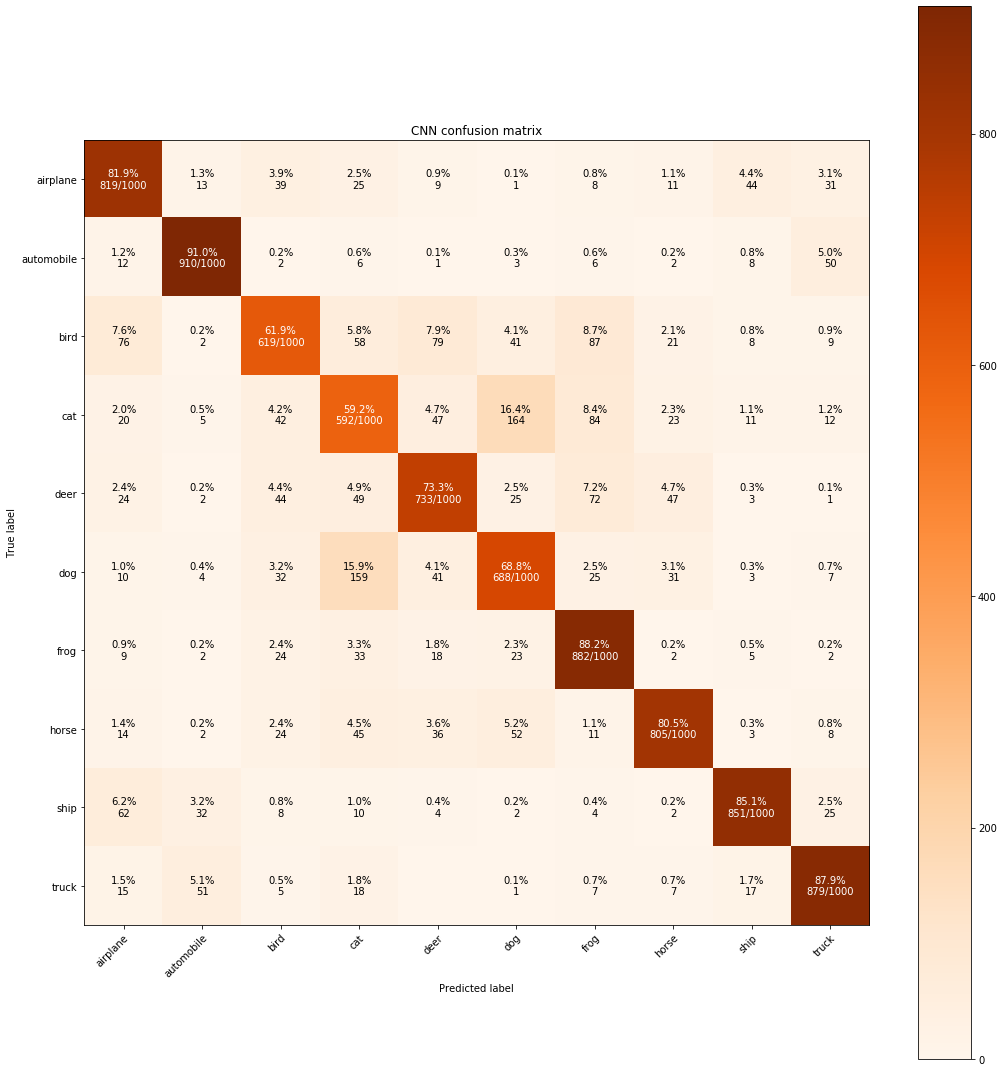

In [26]:
pred_best_cnn = best_CNN_model.predict(X_test)
max_index_row_pred = np.argmax(pred_best_cnn, axis=1)
max_index_row_test = np.argmax(y_test, axis=1)

label_names = ['airplane','automobile','bird','cat',  'deer','dog','frog','horse','ship', 'truck']

plot_confusion_matrix(max_index_row_test, max_index_row_pred, 
                      #classes=['0' ,'1','2','5', '6', '7', '4', '8', '3','9'],
                      classes= label_names,
                      title='CNN confusion matrix',
                     cmap = plt.cm.Oranges
                     )

## Final: comparando os modelos

#### LeNet5:

In [34]:
print("Acuracia em teste:", scores_LeNet[1]*100)

Acuracia em teste: 60.97000241279602


#### NN


In [35]:
print("Acuracia em teste:" , scores_NN[1]*100)

Acuracia em teste: 43.77000033855438


#### CNN:

In [36]:
print("Acuracia em teste:" , scores_CNN[1]*100)

Acuracia em teste: 77.78000235557556
